In [24]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass  #this might not be needed anymore
from os import environ, name
from functions import *
from random import shuffle
from random import seed
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

### Loading the data

In [25]:
if os.name == 'posix':
    data_path=os.environ['HOME']+'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
elif os.name == 'nt':
    data_path=os.environ['HOME']+'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
else:
    raise Exception('OS not recongnized. I\'m confused.')
    
df = pd.read_csv(data_path + 'MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized_DONT_TOUCH_ME.txt')
df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df["student"] = df["student"].astype('category')
df_scores["student"] = df_scores["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()

def remodel_families(row):
    if row["Family"] == "Build" or row["Family"] == "Revise":  # or row["Family"] == "Extra":
        if row["Outcome"] != "None":
            return "ConstructWithFeedback"
        else:
            return "Construct"
    else:
        return row["Family"]
    
df['Family'] = df.apply (lambda row: remodel_families (row),axis=1)

In [139]:
def get_blocks_withTime(df, students, add_spaces = False, ignore = [], start = True):
    '''gets blocks of sequences for a list of students'''
    def convert(action,ignore):
        if action[0] in ignore:
            return ''
        elif action == 'Reset':
            return 'X'
        elif action == 'ConstructWithFeedback':
            return 'F'
        else: 
            return action[0]
    if start:
        if add_spaces:
            blocks = {student:'S ' for student in students}
        else:
            blocks = {student:'S' for student in students}
    else:
        blocks = {student:'' for student in students}
    for student in students:
        sequence =  list(df[df['student']==student]['Family'])
        time_stamps =  list(df[df['student']==student]['Time Stamp'])
        time_stamps = (time_stamps - min(time_stamps))/1000  #human readable seconds
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'(.)\1*')  #this regex finds all action blocks of length 1+
        #use finditer to return a sequence of matches as an iterator 
        for match in p.finditer(''.join([convert(action,ignore) for action in sequence])):
            ind = match.span()  #this gives start and end of matched block
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'(.)\1+', r'\1',''.join([convert(action,ignore) for action in sequence]))
        if add_spaces:
            spaced_block = block[0]
            for b in block[1:]:
                spaced_block += ' '+b
            blocks[student] += spaced_block
        else:
            blocks[student] += block
    return blocks, time_coord

In [291]:
def plot_barGraph(ACTIVITY, studentID, pltFamilies):
    
    #get blocks of actions and their time coordinate for broken bar plot
    blocks, time_coord = get_blocks_withTime(df[df.Activity==ACTIVITY],{studentID},add_spaces=True, ignore = [], start = False)
    #create figure and axes
    fig, ax = plt.subplots()
    #set figure size
    matplotlib.rcParams['figure.figsize'] = 15, 9
    #need this to convert desired action families back to letter code
    def convert(action,ignore):
            if action[0] in ignore:
                return ''
            elif action == 'Reset':
                return 'X'
            elif action == 'ConstructWithFeedback':
                return 'F'
            else: 
                return action[0]
    nn=1
    colorArr=iter(plt.cm.rainbow(np.linspace(0,1,len(pltFamilies))))
    for action in pltFamilies: 
        #next 2 lines sample out relevant action blocks for one broken horizontal bar
        out = [(x,y) for x,y in zip(blocks[studentID].split(),time_coord) if any(convert(action,[])==z for z in x)]
        junk, time_coord_filtered = map(list,zip(*out))  
        ax.broken_barh(time_coord_filtered,(10*nn,9),facecolors=next(colorArr))
        nn+=1
    
    ax.set_ylim(5, len(pltFamilies)*10+15)
    ax.set_xlim(0, time_coord[-1][0]+time_coord[-1][1]+2)
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_yticks(range(15,len(pltFamilies)*10+15,10))
    ax.set_yticklabels(pltFamilies, fontsize=14)
    ax.grid(True)
    
    plt.show()


## Plot broken bar plots for both activities and different archtypical students

In [279]:
#Define what action families to plot and in what order.
#pltFamilies=['Construct', 'Organize', 'Interface', 'Extra', 'Pause', 'Test', 'ConstructWithFeedback', 'Reset']
pltFamilies=['Construct', 'Organize', 'ConstructWithFeedback','Pause', 'Test']

### Lightbulb activity 

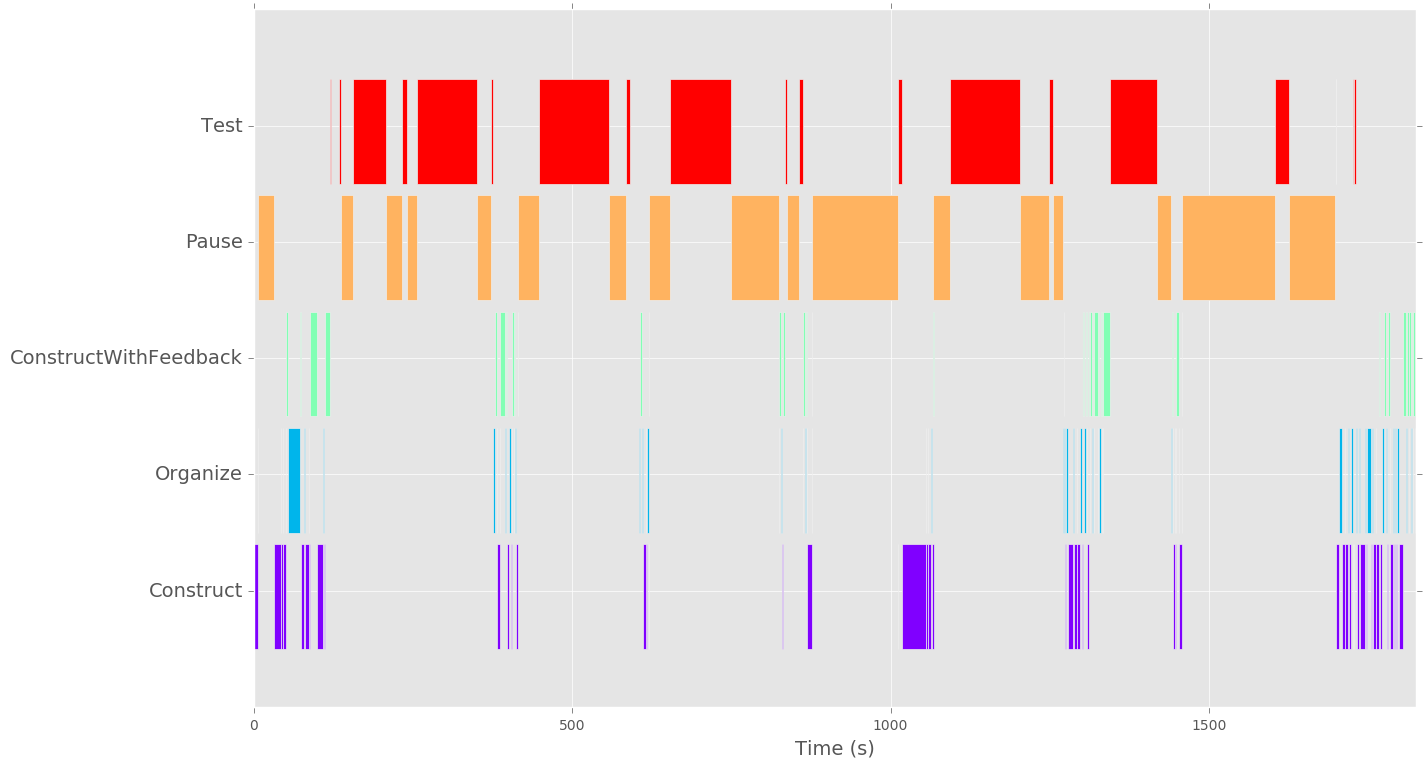

In [292]:
plot_barGraph('a1', 94792123, pltFamilies)  #largest learning gain student

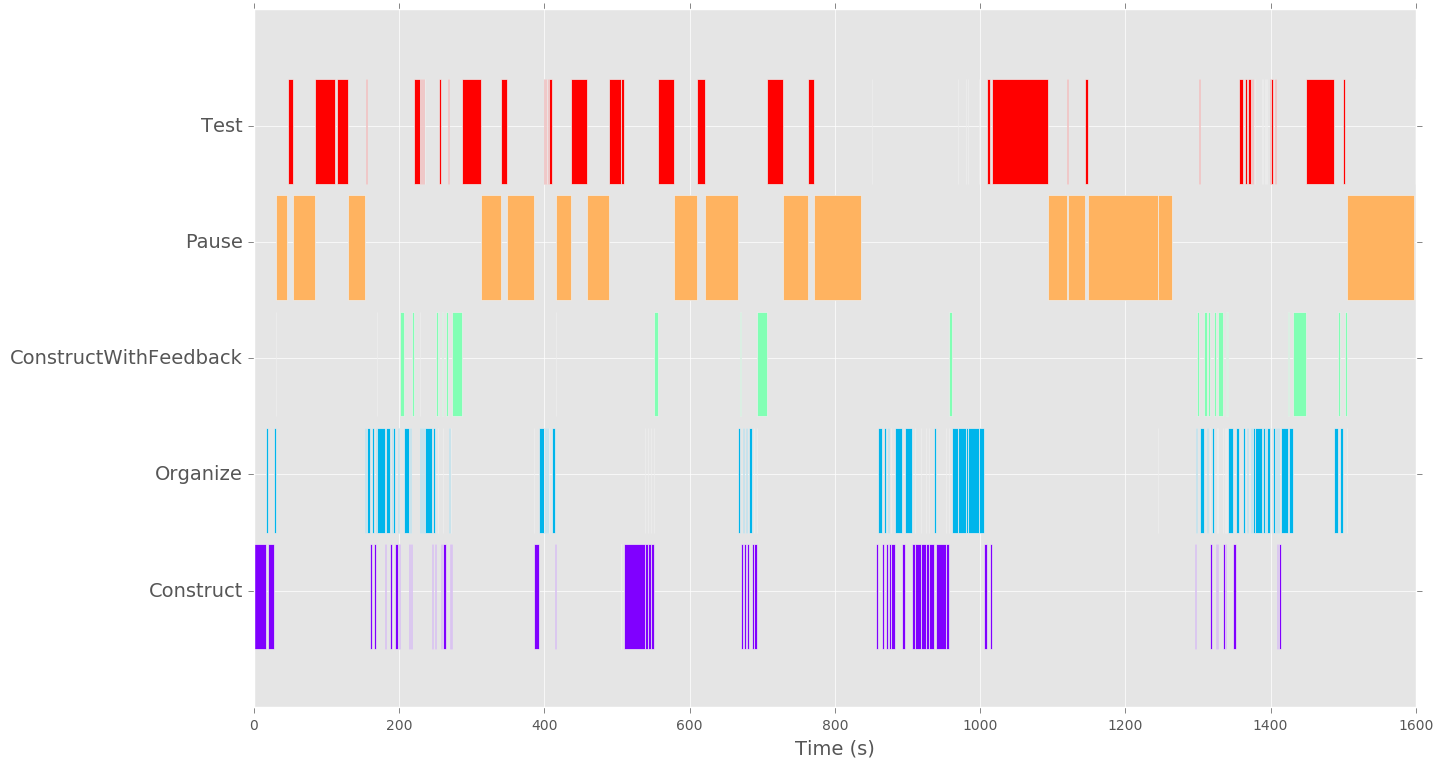

In [281]:
plot_barGraph('a1',3591123, pltFamilies) #worst learning gain student

### Resistor activity

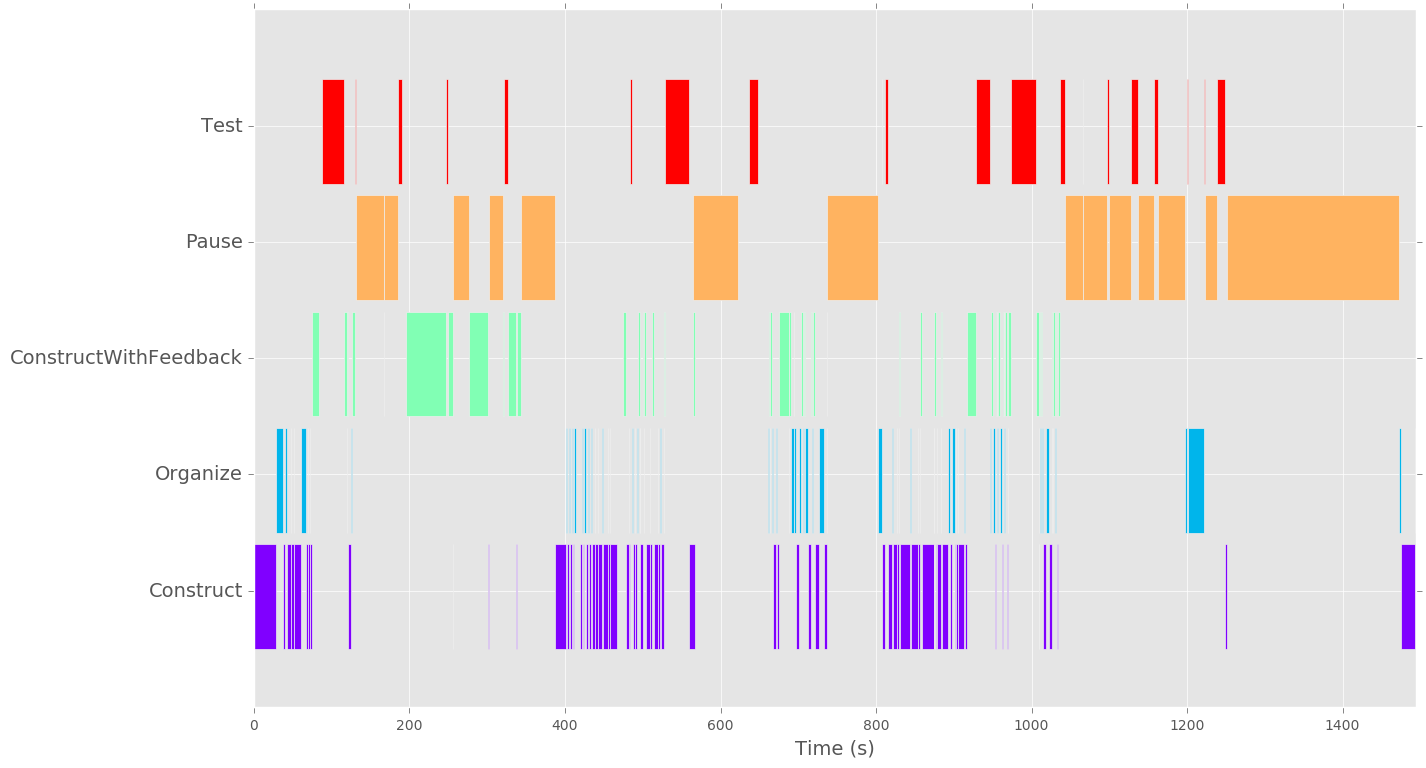

In [282]:
plot_barGraph('a2', 94792123, pltFamilies)  #largest learning gain student

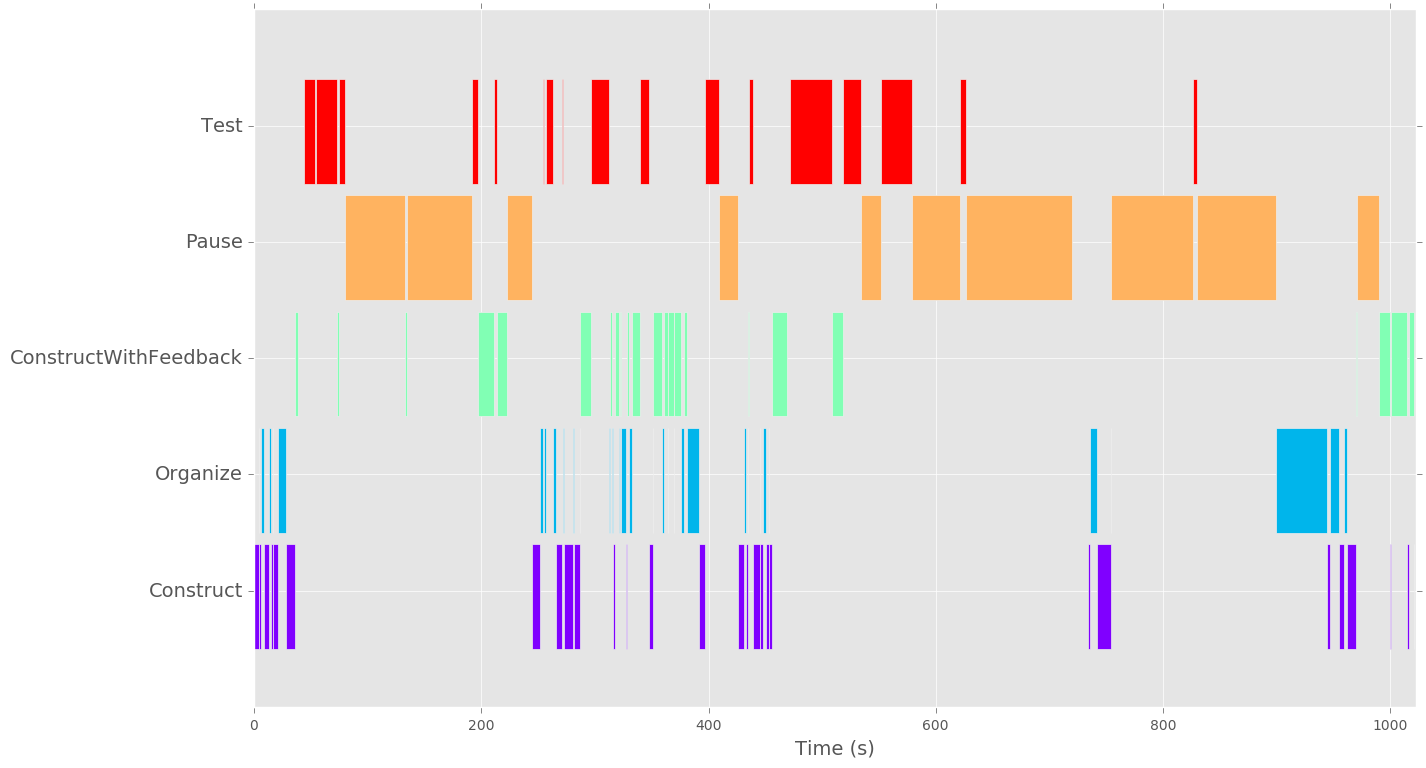

In [283]:
plot_barGraph('a2',3591123, pltFamilies) #worst learning gain student